<img src ="Images/GatorGlaciologyLogo-01.jpg" width="100" align = "right">

# Interpolation with a trend
#### Gator Glaciology Lab, University of Florida

Geologic phenomena often have large-scale trends that override small-scale variability. As such, trends can make it difficult to model the variograms. As such, it is sometimes helpful to detrend the data prior to interpolation. The interpolation is then performed on the detrended data, and the interpolated result is added back to the trend.

<img src ="Images/detrending_schematic-01.jpg" width="800" align = "center">

Linear and polynomial trends are often used. However, we believe that non-parametric approaches are more versatile, especially for complex examples. Here we show how to use radial basis functions (RBFs) to estimate the trend. We uses this to perform kriging and SGS with a trend.

In [1]:
# load dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import geostatspy.geostats as geostats 
import GStatSim as gs
import skgstat as skg
from skgstat import models
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import random

## Load and plot data

<function matplotlib.pyplot.show(close=None, block=None)>

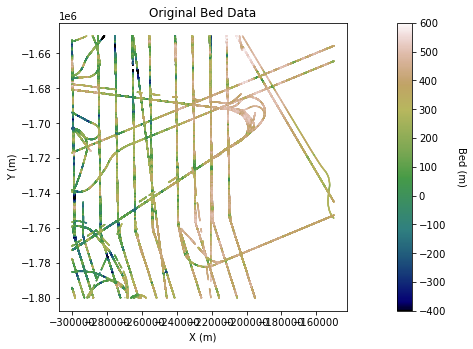

In [2]:
df_bed = pd.read_csv('Data/greenland_test_data.csv') # download data
df_bed = df_bed[df_bed["Bed"] <= 700]  # remove erroneously high values, presumably due to bad bed picks

# plot original data
im = plt.scatter(df_bed['X'],df_bed['Y'], c = df_bed['Bed'], vmin = -400, vmax = 600, marker=".", s = 0.5, 
                 cmap = 'gist_earth')       # scatter plot for location map
plt.title('Original Bed Data')                                    # add plot title
plt.xlabel('X (m)'); plt.ylabel('Y (m)')                          # set axis labels
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(-400, 600, 11)) # add vertical color bar
cbar.set_label("Bed (m)", rotation=270, labelpad=20)      # add labels to the color bar
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0) # adjust the plot size
plt.axis('scaled')
plt.show

## Grid data

In [3]:
# Grid data
res = 1000  # resolution
df_grid, grid_matrix, rows, cols = gs.grid_data(df_bed, 'X', 'Y', 'Bed', res) # grid data
df_grid = df_grid[df_grid["Z"].isnull() == False]  # remove coordinates with NaNs
df_grid = df_grid.rename(columns = {"Z": "Bed"}) # rename column for consistency

## Compute trend

In [4]:
smooth_radius = 100000 # smoothing radius for RBF function (100 km)
trend_rbf = gs.rbf_trend(grid_matrix, smooth_radius, res)

<Figure size 432x288 with 0 Axes>

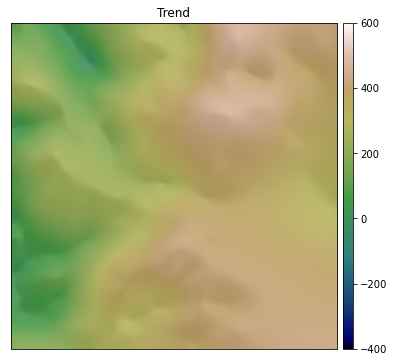

In [5]:
# plot hillshade map of trend

hillshade = es.hillshade(trend_rbf, azimuth = 210, altitude = 10) # hillshade

fig = plt.figure()
fig, ax = plt.subplots(figsize=(10, 6))
ep.plot_bands(
    trend_rbf,
    ax=ax,
    cmap="gist_earth",
    title="Trend",
    vmin = -400, vmax = 600,
)
ax.imshow(hillshade, cmap="Greys", alpha=0.1)
plt.show()

## Compute residual from trend

<function matplotlib.pyplot.show(close=None, block=None)>

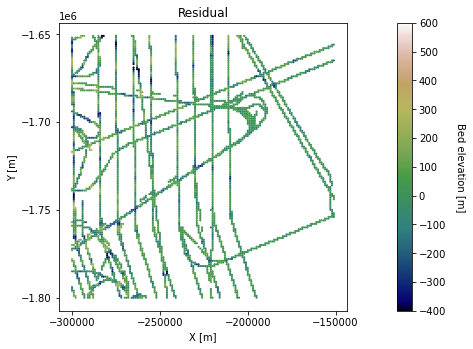

In [6]:
# subtract trend from data
diff = grid_matrix - trend_rbf
diff = np.flipud(diff) # flip matrix

# remove NaNs, add to dataframe
ny, nx = diff.shape
diff_array = np.reshape(diff,[ny*nx])
diff_array = diff_array[~np.isnan(diff_array)]
df_grid['Residual'] = diff_array

# plot residual 
fig = plt.figure()
im = plt.scatter(df_grid['X'],df_grid['Y'], c = df_grid['Residual'], vmin = -400, vmax = 600, marker=".", s = 5, 
                 cmap = 'gist_earth')       # scatter plot for location map
plt.title('Residual')                                    # add plot title
plt.xlabel('X [m]'); plt.ylabel('Y [m]')                          # set axis labels
plt.locator_params(nbins=5)# set axis labels
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(-400, 600, 11)) # add vertical color bar
cbar.set_label("Bed elevation [m]", rotation=270, labelpad=20)      # add labels to the color bar
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0) # adjust the plot size
plt.axis('scaled')
plt.show

## Normal score transformation for residual data

In [7]:
df_grid['Nres'], tvbed, tnsbed = geostats.nscore(df_grid,'Residual')  # normal score transformation of residual

## Variogram analysis for residual data

In [8]:
# compute experimental (isotropic) variogram
coords = df_grid[['X','Y']].values
values = df_grid['Nres']

maxlag = 50000 # maximum range distance
n_lags = 70 #num of bins

V1 = skg.Variogram(coords, values, bin_func = "even", n_lags = n_lags, 
                   maxlag = maxlag, normalize=False)

# extract variogram values
xdata = V1.bins
ydata = V1.experimental

V1.model = 'exponential' # use exponential variogram model

In [9]:
# set variogram parameters
vrange = V1.parameters[0]
vsill = V1.parameters[1]
vnugget = V1.parameters[2]

# evaluate models
xi =np.linspace(0, xdata[-1], 1000) 
y_exp = [models.exponential(h, vrange, vsill, vnugget) for h in xi]

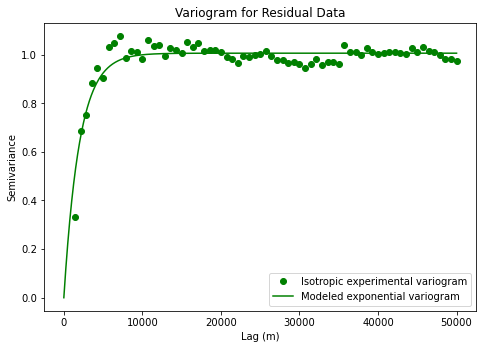

In [10]:
# plot variogram model
plt.plot(xdata,ydata,'og', label = "Isotropic experimental variogram")
plt.plot(xi,y_exp,'-g', label = "Modeled exponential variogram")
plt.title('Variogram for Residual Data')
plt.xlabel('Lag (m)'); plt.ylabel('Semivariance')  
plt.subplots_adjust(left=0.0, bottom=0.0, right=1, top=1) # adjust the plot size
plt.legend(loc='lower right')

The variogram sill here reaches 1, which makes sense because the variance of data with a standard Gaussian distribution should in theory be 1. In contrast, the variogram for the non-detrended data in Tutorial 2 (2_Variogram_model.ipynb) did not have a variogram of 1, which is a less desirable condition. As such, using the residual can lead to better variogram modeling, which makes the interpolation functions more effective.

## Initialize grid

Make list of grid cells that need to be simulated.

In [11]:
# define coordinate grid
xmin = np.min(df_grid['X']); xmax = np.max(df_grid['X'])     # min and max x values
ymin = np.min(df_grid['Y']); ymax = np.max(df_grid['Y'])     # min and max y values

Pred_grid_xy = gs.pred_grid(xmin, xmax, ymin, ymax, res)

## Kriging with a trend

Here will apply a kriging interpolation to the residual and add it to the trend. This procedure is known as kriging with a trend or universal kriging. Note that simple kriging should be used to krige the residual because the detrended data set has a constant mean.

In [12]:
# set variogram parameters
Azimuth = 0
nug = V1.parameters[2]
# the major and minor ranges are the same in this example because it is isotropic
a_maj = V1.parameters[0]
a_min = V1.parameters[0]
sill = 1 
vario = [Azimuth, nug, a_maj, a_min, sill] # save variogram parameters as a list

k = 100 # number of neighboring data points used to estimate a given point 
rad = 50000 # 50 km search radius

est_SK, var_SK = gs.skrige(Pred_grid_xy, df_grid, 'X', 'Y', 'Nres', k, vario, rad) 
# est_SK is the estimate and var_SK is the variance

100%|████████████████████████████████████| 22500/22500 [02:37<00:00, 142.54it/s]


In [13]:
# reverse normal score transformation
df_skrige = pd.DataFrame(est_SK, columns = ['pred'])

# transformation parameters
vr = tvbed; vrg = tnsbed; ltail = 1; utail = 1; zmin = -4; zmax = 4; ltpar = -1500; utpar = 1500

# transformation
spred_trans = geostats.backtr(df_skrige,'pred',vr,vrg,zmin,zmax,ltail,ltpar,utail,utpar)

<Figure size 432x288 with 0 Axes>

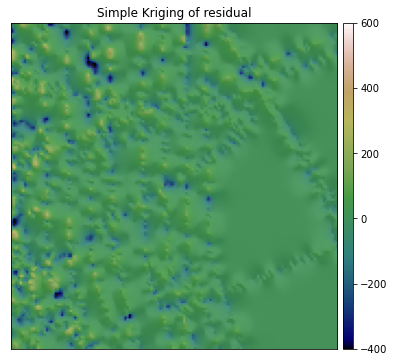

In [14]:
# plot kriging interpolation of residual

# make hillshade plot for visualizing

# reshape grid
ylen = (ymax + res - ymin)/res
xlen = (xmax + res - xmin)/res
elevation =  np.reshape(spred_trans, (int(ylen), int(xlen)))
elevation = elevation 

hillshade = es.hillshade(elevation, azimuth = 210, altitude = 10) # hillshade

fig = plt.figure()
fig, ax = plt.subplots(figsize=(10, 6))
ep.plot_bands(
    elevation,
    ax=ax,
    cmap="gist_earth",
    title="Simple Kriging of residual",
    vmin = -400, vmax = 600,
)
ax.imshow(hillshade, cmap="Greys", alpha=0.1)
plt.show()

Now let's add the trend:

<Figure size 432x288 with 0 Axes>

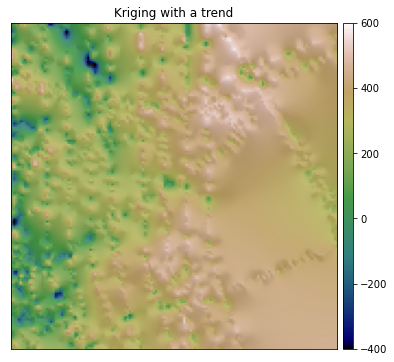

In [15]:
# add trend to kriging result

sk_total = elevation + trend_rbf

hillshade = es.hillshade(sk_total, azimuth = 210, altitude = 10) # hillshade

fig = plt.figure()
fig, ax = plt.subplots(figsize=(10, 6))
ep.plot_bands(
    sk_total,
    ax=ax,
    cmap="gist_earth",
    title="Kriging with a trend",
    vmin = -400, vmax = 600,
)
ax.imshow(hillshade, cmap="Greys", alpha=0.1)
plt.show()

## Sequential Gaussian simulation

Now we will apply SGS to the residual. We will use the version of SGS that uses simple kriging.

In [16]:
# SGS
vario = [Azimuth, nug, a_maj, a_min, sill] # save variogram parameters as a list

sim = gs.skrige_SGS(Pred_grid_xy, df_grid, 'X', 'Y', 'Nres', k, vario, rad) 

100%|████████████████████████████████████| 22500/22500 [03:12<00:00, 117.18it/s]


In [17]:
# reverse normal score transformation
df_sim= pd.DataFrame(sim, columns = ['sim'])

# transformation parameters
vr = tvbed; vrg = tnsbed; ltail = 1; utail = 1; zmin = -4; zmax = 4; ltpar = -1500; utpar = 1500

# transformation
sim_trans = geostats.backtr(df_sim,'sim',vr,vrg,zmin,zmax,ltail,ltpar,utail,utpar)

<Figure size 432x288 with 0 Axes>

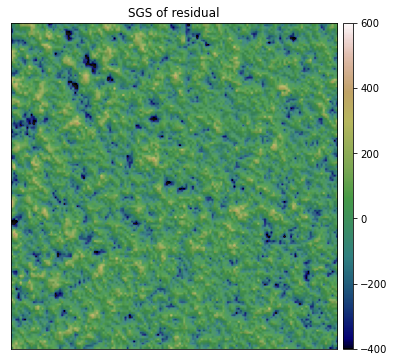

In [18]:
# make hillshade plot for visualizing

# reshape grid
ylen = (ymax + res - ymin)/res
xlen = (xmax + res - xmin)/res
elevation =  np.reshape(sim_trans, (int(ylen), int(xlen)))
elevation = elevation 

hillshade = es.hillshade(elevation, azimuth = 210, altitude = 10) # hillshade

fig = plt.figure()
fig, ax = plt.subplots(figsize=(10, 6))
ep.plot_bands(
    elevation,
    ax=ax,
    cmap="gist_earth",
    title="SGS of residual",
    vmin = -400, vmax = 600,
)
ax.imshow(hillshade, cmap="Greys", alpha=0.1)
plt.show()

<Figure size 432x288 with 0 Axes>

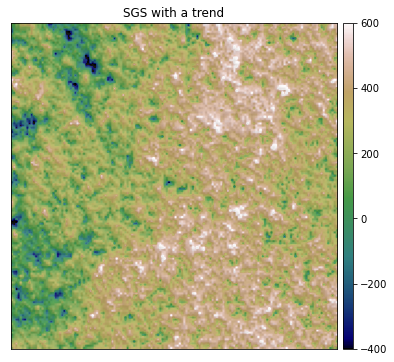

In [19]:
# add trend
sgs_total = elevation + trend_rbf

hillshade = es.hillshade(sgs_total, azimuth = 210, altitude = 10) # hillshade

fig = plt.figure()
fig, ax = plt.subplots(figsize=(10, 6))
ep.plot_bands(
    sgs_total,
    ax=ax,
    cmap="gist_earth",
    title="SGS with a trend",
    vmin = -400, vmax = 600,
)
ax.imshow(hillshade, cmap="Greys", alpha=0.1)
plt.show()

## Variogram analysis

Let's compare the variograms of the residual data and the SGS residual to assess simulation performance.

In [20]:
# compute SGS variogram

# downsample random indices to speed this up
rand_indices = random.sample(range(np.shape(Pred_grid_xy)[0]),5000) # generate random numbers to keep

coords_s = Pred_grid_xy[rand_indices]
values_s = sim[rand_indices]  # notice that we're using the simulated topography values prior to back transformation 
#because the experimental variogram was computed on normalized data

VS = skg.Variogram(coords_s, values_s, bin_func = "even", n_lags = n_lags, 
                   maxlag = maxlag, normalize=False)

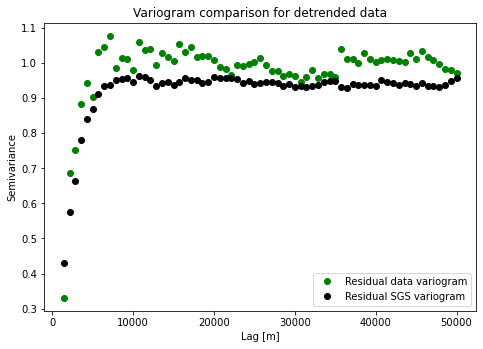

In [21]:
# plot variogram

# extract variogram values

# experimental variogram (from beginning of script)
xe = V1.bins
ye = V1.experimental

# simple kriging variogram
xs = VS.bins
ys = VS.experimental

fig = plt.figure()
plt.plot(xe,ye,'og', label = 'Residual data variogram')
plt.plot(xs,ys,'ok', label = 'Residual SGS variogram')
plt.title('Variogram comparison for detrended data')
plt.xlabel('Lag [m]'); plt.ylabel('Semivariance')  
plt.subplots_adjust(left=0.0, bottom=0.0, right=1, top=1) # adjust the plot size
plt.legend(loc='lower right')

Compared to Tutorial 4 (4_Sequential_Guassian_Simulation.ipynb), the variograms have better agreement.